# Reduction of dimensionality

See [A Tutorial on Principal Component Analysis](https://www.cs.princeton.edu/picasso/mats/PCA-Tutorial-Intuition_jp.pdf) for an intuitive and detailed description of PCA and SVD

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition, datasets
%matplotlib inline

In [2]:

def plot_data(X, y):
    y_unique = np.unique(y)
    colors = plt.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        plt.scatter(this_X[:, 0], this_X[:, 1],  color=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    plt.legend(loc="best")
    plt.title("Data")

## Intuition

We then present the following 2D data and want to find a 1D projection that preserves the maximum amount of variability.

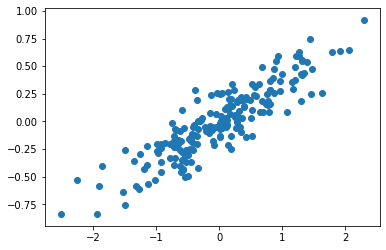

In [3]:
np.random.seed(1)
X = np.dot(np.random.random(size=(2, 2)), np.random.normal(size=(2, 200))).T+10

# Centra los datos en 0,0
X=X-np.mean(X, axis=0)

plt.scatter(X[:,0], X[:,1])

Recall that the projection of a vector $ \vec {x} $ into another vector $ \vec {v} $ (see [here](https://matthew-brett.github.io/teaching/vector_projection.html)) comes given by:

$$ c = \frac {\vec {v} \cdot \vec {x}} {|| \vec {v} || ^ 2} $$


$$ proj_ \vec {v} \vec {x} = \vec {v} c $$


where $ c $ is the size of the projection of $ \vec {x} $ on $ \vec {v} $

### Let's inspect some projections

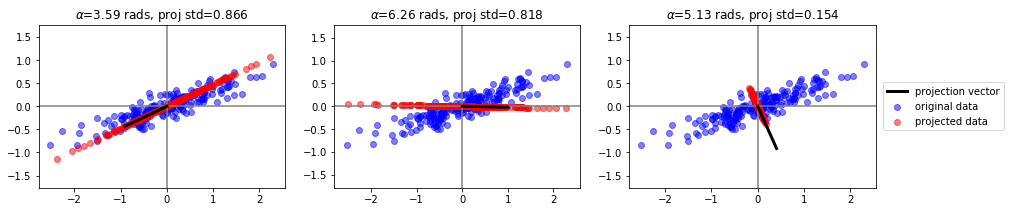

In [4]:
plt.figure(figsize=(15,3))

unit_vector = lambda angle: np.array([np.cos(angle), np.sin(angle)])

for i in range(3):
    plt.subplot(1,3,i+1)
    angle = np.random.random()*np.pi*2
    v = unit_vector(angle)

    c = X.dot(v.reshape(-1,1))/(np.linalg.norm(v)**2)
    Xp = np.repeat(v.reshape(-1,2),len(X),axis=0)*c

    plt.scatter(X[:,0], X[:,1], color="blue", alpha=.5, label="original data")
    plt.scatter(Xp[:,0], Xp[:,1], color="red", alpha=.5, label="projected data")
    plt.axvline(0, color="gray")
    plt.axhline(0, color="gray")
    plt.plot([0,v[0]], [0,v[1]], color="black", lw=3, label="projection vector")
    plt.axis('equal')
    plt.ylim(-2,2)
    plt.title("$\\alpha$=%.2f rads, proj std=%.3f"%(angle, np.std(c)))
    if i==2:
        plt.legend(loc="center left", bbox_to_anchor=(1.01,.5))

### Then we want to find the projections with greater and lesser variance by brute force

Text(0, 0.5, 'projection std')

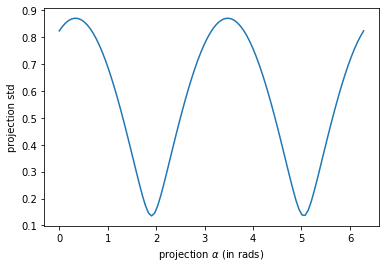

In [5]:
def get_maxmin_projections(X):
    stds = []
    angles = np.linspace(0,np.pi*2, 100)
    for a in angles:
        v = np.array([np.cos(a), np.sin(a)])
        c = X.dot(v.reshape(-1,1))/(np.linalg.norm(v)**2)
        stds.append(np.std(c))
    v2 = unit_vector(angles[np.argmin(stds)])
    v1 = unit_vector(angles[np.argmax(stds)])
    
    return angles, stds, v1, v2

angles, stds, v1, v2 = get_maxmin_projections(X)

plt.plot(angles, stds)
plt.xlabel("projection $\\alpha$ (in rads)")
plt.ylabel("projection std")

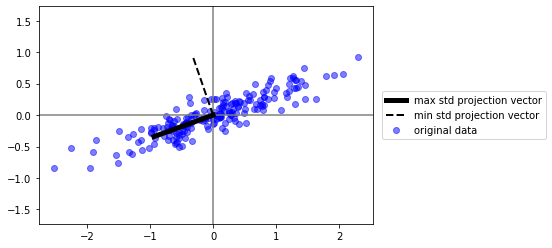

In [6]:
plt.scatter(X[:,0], X[:,1], color="blue", alpha=.5, label="original data")
plt.axvline(0, color="gray")
plt.axhline(0, color="gray")
plt.plot([0,v1[0]], [0,v1[1]], color="black", lw=5, label="max std projection vector")
plt.plot([0,v2[0]], [0,v2[1]], color="black", ls="--", lw=2, label="min std projection vector")
plt.axis('equal')
plt.ylim(-2,2)
plt.legend(loc="center left", bbox_to_anchor=(1.01,.5))


## Principal component analysis (PCA)
[Help Video](https://www.youtube.com/watch?v=FgakZw6K1QQ)

Principal component analysis (PCA) is a technique used to describe a data set in terms of uncorrelated new variables ("components"). Components are ordered by the amount of original variance they describe, so the technique is useful for reducing the dimensionality of a data set.

In other words, the PCA technique seeks the projection according to which the data are best represented in terms of least squares. That is, it converts a set of possibly correlated variable observations into a set of non-linearly correlated variable values ​​called principal components. This technique is mainly used in exploratory data analysis and in the construction of predictive models.

**Limitations:**
  * Linearity assumption: It is assumed that the observed data is a linear combination of a certain base.
  * Statistical importance of the mean and covariance: PCA uses the eigenvectors of the covariance matrix and only finds the directions of axes in the variable space considering that the data is distributed in a Gaussian way.




Taken from: https://es.wikipedia.org/wiki/An%C3%A1álisis_de_componentes_principales

1. We calculate the covariance matrix to express the relationships between our features
2. We find the eigenvectors and eigenvalues of this matrix to measure the strength and variability of these relationships.
3. We order and choose the eigenvectors with greater variability (those that provide more information)

![alt text](https://blog-c7ff.kxcdn.com/blog/wp-content/uploads/2018/07/pca.gif)

### Variance explained for the main components

The total variance is the sum of the variances of all the individual principal components.
Therefore, the variance fraction explained by a principal component is the relationship between the variance of that principal component and the total variance.
On the other hand, if you want to know the percentage of total variance of several main components; Add their variances and divide by the total variance.
This information can be obtained with the attribute `explained_variance_ratio_`

![alt text](https://qph.fs.quoracdn.net/main-qimg-390d70c60aad66494186e4b9b288459f)
 
**Let's compare the principal components analysis with the components obtained by brute force**.
**We can see that the dimensionality is the same as the original data**: 

In [7]:
from sklearn.decomposition import PCA, IncrementalPCA
pca = PCA(n_components=2) 
pca.fit(X)
print("sklearn PCA components")
print(pca.components_)
print("brute force components")
print(v1)
print(v2)

sklearn PCA components
[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]
brute force components
[-0.93969262 -0.34202014]
[-0.32706796  0.94500082]


But much more efficiently

In [8]:
%timeit pca.fit(X)

170 µs ± 4.06 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [9]:
%timeit get_maxmin_projections(X)

3.32 ms ± 19.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### We can use the major component to reduce the dimensionality of our data from 2D to 1D

Note that:

$$ \mathbf {X_t} = \mathbf {X} \cdot \mathbf {V} $$

where:
- $ \mathbf {X} $ is our data
- $ \mathbf {V} $ is the vector of selected components
- $ \mathbf {X_t} $ are the transformed data

so we are restricting ourselves to **linear transformations** (rotations and scaling)

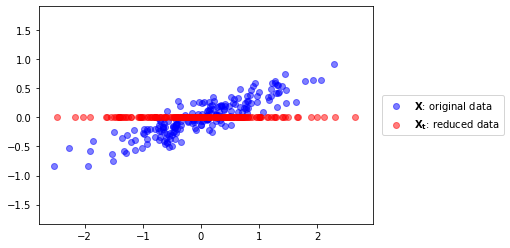

In [10]:
pca = PCA(n_components=1) 
pca.fit(X)
Xt = pca.transform(X)
plt.scatter(X[:,0], X[:,1], color="blue", alpha=.5, label="$\mathbf{X}$: original data")
plt.scatter(Xt, [0]*len(Xt), color="red", alpha=.5, label="$\mathbf{X_t}$: reduced data")
plt.axis("equal");
plt.legend(loc="center left", bbox_to_anchor=(1.01,.5))

And we can also rebuild the 2D data after the transformation

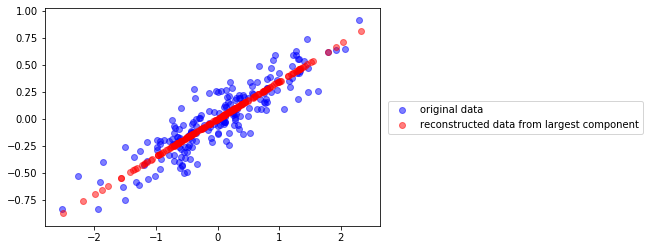

In [11]:
Xr = pca.inverse_transform(Xt)
plt.scatter(X[:,0], X[:,1], color="blue", alpha=.5, label="original data")
plt.scatter(Xr[:,0], Xr[:,1], color="red", alpha=.5, label="reconstructed data from largest component")
plt.legend(loc="center left", bbox_to_anchor=(1.01,.5))

The explained variance is obtained from the attribute `explained_variance_ratio_`:

In [12]:
pca = PCA(n_components=2) 
pca.fit(X)
pca.explained_variance_ratio_

array([0.97634101, 0.02365899])

The result indicates that the first component explains 97.6% of the variance and the second component the remaining 2.4%.

## PCA - Cancer Dataset

In [13]:
from sklearn.datasets import load_breast_cancer
breast = load_breast_cancer()
df = breast.data
df.shape

(569, 30)

In [14]:
y = breast.target
y.shape

(569,)

In [15]:
labels = np.reshape(y,(569,1))

In [16]:
df = np.concatenate([df,labels],axis=1)

In [17]:
df.shape

(569, 31)

In [18]:
df = pd.DataFrame(df)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [19]:
features = breast.feature_names
features

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [20]:
features_labels = np.append(features,'label')

In [21]:
df.columns = features_labels
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,label
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [22]:
df['label'].replace({0:'Benign', 1:'Malignant'},inplace=True)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,label
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,Benign
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,Benign
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,Benign
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,Benign
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,Benign


In [23]:
x = df.loc[:, features].values
x = StandardScaler().fit_transform(x) 

In [24]:
feat_cols = ['feature'+str(i) for i in range(x.shape[1])]
ndf = pd.DataFrame(x,columns=feat_cols)
ndf.head()

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,...,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,...,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


In [25]:
pca = PCA(n_components=2)
pca_breast = pca.fit_transform(x)

In [26]:
pca_df = pd.DataFrame(data = pca_breast
             , columns = ['pc1', 'pc2'])
pca_df.head()

,pc1,pc2
0,9.192837,1.948583
1,2.387802,-3.768172
2,5.733896,-1.075174
3,7.122953,10.275589
4,3.935302,-1.948072


In [27]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.44272026 0.18971182]


<Figure size 432x288 with 0 Axes>

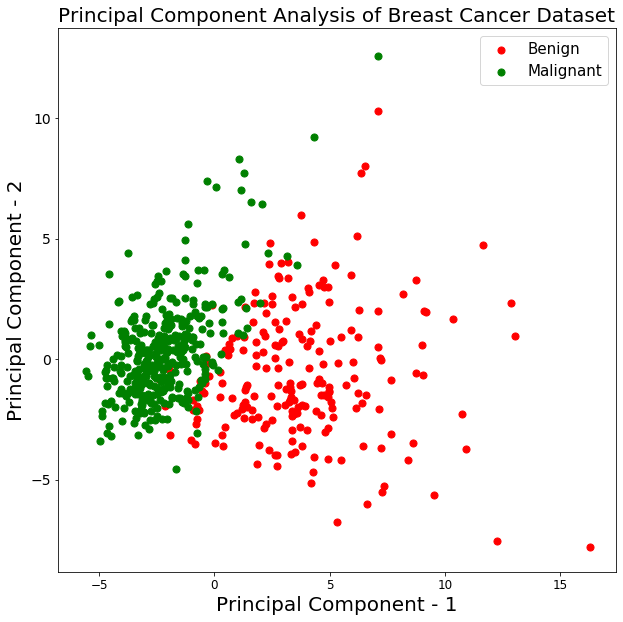

In [28]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Breast Cancer Dataset",fontsize=20)
targets = ['Benign', 'Malignant']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = df['label'] == target
    plt.scatter(pca_df.loc[indicesToKeep, 'pc1']
               , pca_df.loc[indicesToKeep, 'pc2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})

In [29]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,label
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,Benign
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,Benign
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,Benign
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,Benign
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,Benign


In [30]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['label'] = le.fit_transform(df['label'])

le.classes_
x = df.drop(['label'], 1)
x = StandardScaler().fit_transform(x)
y = df['label']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)


In [31]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = svm.SVC(kernel='rbf', gamma='scale')
knn = KNeighborsClassifier(n_neighbors=2)
lr = LogisticRegression(solver='lbfgs', max_iter=2000)


pca = PCA(n_components=2)
pca_x_train = pca.fit_transform(x_train)
pca_x_test = pca.fit_transform(x_test)


############################### SVC
print("-"*32, "SVC")
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print('Without PCA: ', accuracy_score(y_pred, y_test))

clf.fit(pca_x_train, y_train)
pca_pred = clf.predict(pca_x_test)
print('With PCA: ', accuracy_score(pca_pred, y_test))

############################## KNN
print("-"*32, "KNN")
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
print('Without PCA: ', accuracy_score(y_pred, y_test))

knn.fit(pca_x_train, y_train)
pca_pred = knn.predict(pca_x_test)
print('With PCA: ', accuracy_score(pca_pred, y_test))

############################## LR
print("-"*32, "LR")
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print('Without PCA: ', accuracy_score(y_pred, y_test))

lr.fit(pca_x_train, y_train)
pca_pred = lr.predict(pca_x_test)
print('With PCA: ', accuracy_score(pca_pred, y_test))


-------------------------------- SVC
Without PCA:  0.9736842105263158
With PCA:  0.9210526315789473
-------------------------------- KNN
Without PCA:  0.9298245614035088
With PCA:  0.8947368421052632
-------------------------------- LR
Without PCA:  0.9649122807017544
With PCA:  0.9035087719298246


In [32]:
## No Normalization
x = df.drop(['label'], 1)
y = df['label']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

clf = svm.SVC(kernel='rbf', gamma='scale')
knn = KNeighborsClassifier(n_neighbors=2)
lr = LogisticRegression(solver='lbfgs', max_iter=2000)


pca = PCA(n_components=2)
pca_x_train = pca.fit_transform(x_train)
pca_x_test = pca.fit_transform(x_test)


############################### SVC
print("-"*32, "SVC")
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print('Without PCA: ', accuracy_score(y_pred, y_test))

clf.fit(pca_x_train, y_train)
pca_pred = clf.predict(pca_x_test)
print('With PCA: ', accuracy_score(pca_pred, y_test))

############################## KNN
print("-"*32, "KNN")
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
print('Without PCA: ', accuracy_score(y_pred, y_test))

knn.fit(pca_x_train, y_train)
pca_pred = knn.predict(pca_x_test)
print('With PCA: ', accuracy_score(pca_pred, y_test))

############################## LR
print("-"*32, "LR")
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print('Without PCA: ', accuracy_score(y_pred, y_test))

lr.fit(pca_x_train, y_train)
pca_pred = lr.predict(pca_x_test)
print('With PCA: ', accuracy_score(pca_pred, y_test))




-------------------------------- SVC
Without PCA:  0.9298245614035088
With PCA:  0.9035087719298246
-------------------------------- KNN
Without PCA:  0.8947368421052632
With PCA:  0.8421052631578947
-------------------------------- LR
Without PCA:  0.9473684210526315
With PCA:  0.8333333333333334


### PCA - Heart disease

### About our data

1. age: Age in years of the patient 
2. sex: 1 - Man, 2 - Woman 
3. cp: Type of value in the chest among
    - 4 possible values. (1 - Typical angina, 2 - Atypical angina, 3 - Non-anginal pain, 4 - Asymptomatic pain) 
4. trestbps: Resting blood pressure 
5. chol: Cholesterol measurement 
6. fbs: Blood sugar fasting 
7. restcg: resting electrocardiographic results 
8. thalach: maximum heart rate reached 
9. exang: did you develop angina after exercising? 
10. oldpeak: Exercise-induced ST depression relative to rest (More information [here](Https://litfl.com/st-segment-ecg-library/) )
11. slope: Slope of peak of ST segment 
12. ca: Number of major blood vessels stained by fluoroscopy 
13. thal: Thalassemia: 1 - Normal, 2 - Fixed defect, 3 - Reversible defect 
14. target: Presence of cardiac pathology 1 or 0.

In [33]:
df = pd.read_csv('../Datasets/Week9/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [34]:
# Normalize our data

x = df.drop(['target'], 1)
y = df['target']

x = StandardScaler().fit_transform(x) # Normalization

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.3)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((717, 13), (308, 13), (717,), (308,))

PCA: [0.21616516 0.11388309 0.09682792]


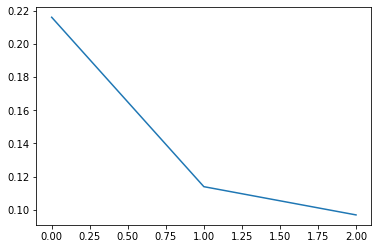

In [35]:
# Default -> n_components = min(n_samples, n_features)
# We have 13 components but that would generate a redundancy, let's try just with 3 components
pca = PCA(n_components=3)

pca.fit(x_train)

# We will use batch_size for incrementalPCA, let's remember batch is a sample of our data
ipca = IncrementalPCA(n_components=3, batch_size=10)
ipca.fit(x_train) 

plt.plot(range(len(pca.explained_variance_)), pca.explained_variance_ratio_)
print('PCA:', pca.explained_variance_ratio_)

- we can see:
    - first component provides almost 20% of our information
    - second component provides almost 12% 
    - third component provides almost no information
- conclusion:
**first and second component provide us almost all data**

In [36]:
# compare pca versus normal data

lr = LogisticRegression(solver='lbfgs')

lr.fit(x_train, y_train)
print('Without PCA: ', lr.score(x_test, y_test))

x_pca_train = pca.transform(x_train)
x_pca_test = pca.transform(x_test)
lr.fit(x_pca_train, y_train)
print('With PCA: ', lr.score(x_pca_test, y_test))


x_ipca_train = ipca.transform(x_train)
x_ipca_test = ipca.transform(x_test)
lr.fit(x_ipca_train, y_train)
print('With IncrementalPCA: ', lr.score(x_ipca_test, y_test))


Without PCA:  0.8214285714285714
With PCA:  0.814935064935065
With IncrementalPCA:  0.8084415584415584


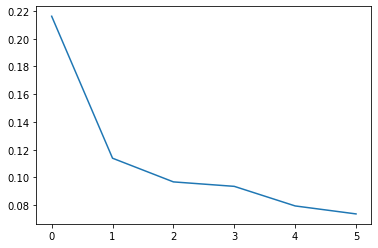

In [37]:
# Let's try with more components
pca = PCA(n_components=6)

pca.fit(x_train)

# We will use batch_size for incrementalPCA, let's remember batch is a sample of our data
ipca = IncrementalPCA(n_components=6, batch_size=10)
ipca.fit(x_train) 

plt.plot(range(len(pca.explained_variance_)), pca.explained_variance_ratio_)

In [38]:
# compare pca versus normal data

lr = LogisticRegression(solver='lbfgs')

lr.fit(x_train, y_train)
print('Without PCA: ', lr.score(x_test, y_test))

x_pca_train = pca.transform(x_train)
x_pca_test = pca.transform(x_test)
lr.fit(x_pca_train, y_train)
print('With PCA: ', lr.score(x_pca_test, y_test))


x_ipca_train = ipca.transform(x_train)
x_ipca_test = ipca.transform(x_test)
lr.fit(x_ipca_train, y_train)
print('With IncrementalPCA: ', lr.score(x_ipca_test, y_test))


Without PCA:  0.8214285714285714
With PCA:  0.8084415584415584
With IncrementalPCA:  0.814935064935065


## PCA - Wine dataset

First we load the wine data set, perform a scaling of the data (mean = 0 and variance = 1) and plot all the characteristics presenting the 3 kinds of wine, as follows:

In [39]:
wine_df = pd.read_csv('../Datasets/Week9/wine.csv')
wine_df.head()
labels = wine_df['Wine']
classes = wine_df['Wine'].unique()
print(classes)
wine_no_classes = wine_df.drop(columns='Wine').copy()
wine_no_classes.head()

[1 2 3]


,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [40]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_x.fit(wine_no_classes.values)
X_scaled = sc_x.transform(wine_no_classes.values)

In [41]:
X_scaled.shape

(178, 13)

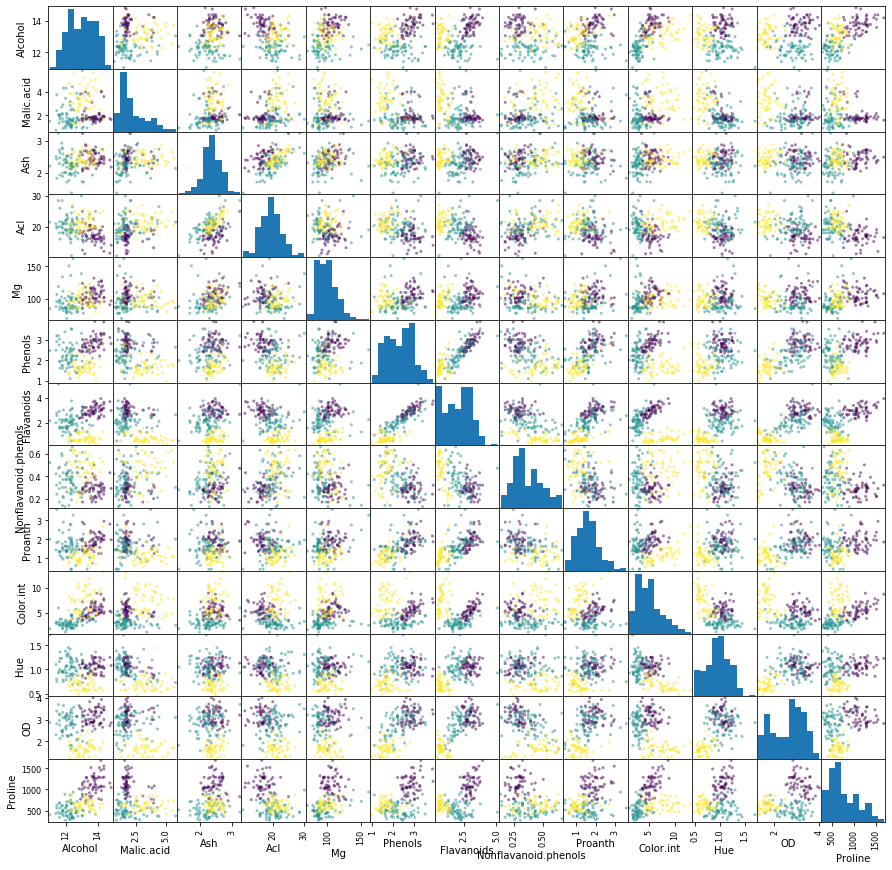

In [42]:
d = pd.plotting.scatter_matrix(wine_no_classes, c=wine_df.Wine,figsize=(15, 15))

Analyzing the explained variance of the main components we obtain the following:

In [43]:
sklearn_pca = PCA(n_components=None)
sklearn_transf = sklearn_pca.fit_transform(X_scaled)
varianza_expl = sklearn_pca.explained_variance_ratio_
varianza_expl

array([0.36198848, 0.1920749 , 0.11123631, 0.0706903 , 0.06563294,
       0.04935823, 0.04238679, 0.02680749, 0.02222153, 0.01930019,
       0.01736836, 0.01298233, 0.00795215])

Next we graph the cumulative curve of the explained variance versus the number of principal components, where we can observe the following:
   * Principal components 1 and 2 represent 55.4% of the variance of the data
   * The first 7 main components represent 89.3% of the variance of the data

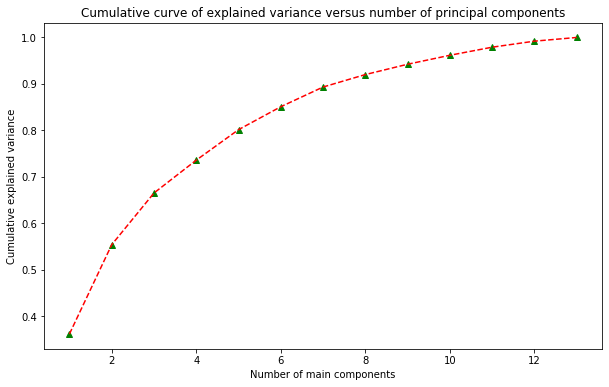

In [44]:
cum_var_exp = np.cumsum(varianza_expl)
plt.figure(figsize = (10, 6))
plt.xlabel('Number of main components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative curve of explained variance versus number of principal components')
nc = np.arange(1, varianza_expl.shape[0] + 1)
plt.plot(nc, cum_var_exp, 'g^')
plt.plot(nc, cum_var_exp, '--r')
plt.show()

We can use the two main components to visualize the data set in 2D. To do this we use the command *sklearn_pca.fit_transform* which, simultaneously, calculates the main components and transforms the original data by projecting them onto them:

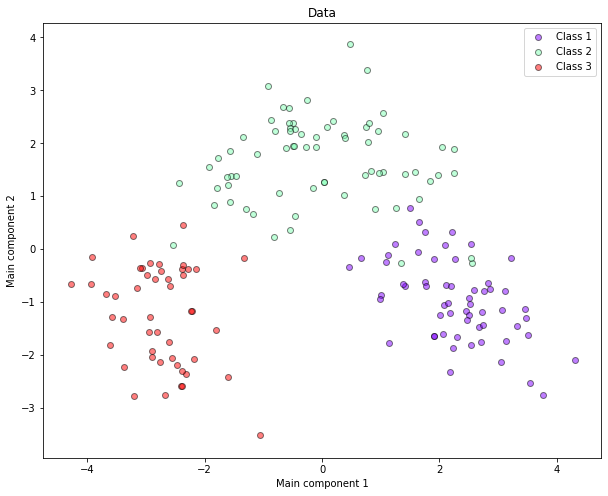

In [45]:
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

sklearn_pca = PCA(n_components=2)
sklearn_transf = sklearn_pca.fit_transform(X_scaled)
plt.figure(figsize = (10, 8))
plt.xlabel('Main component 1')
plt.ylabel('Main component 2')
plt.title('Most significant singular vectors after linear transformation through PCA')
plot_data(sklearn_transf,labels)

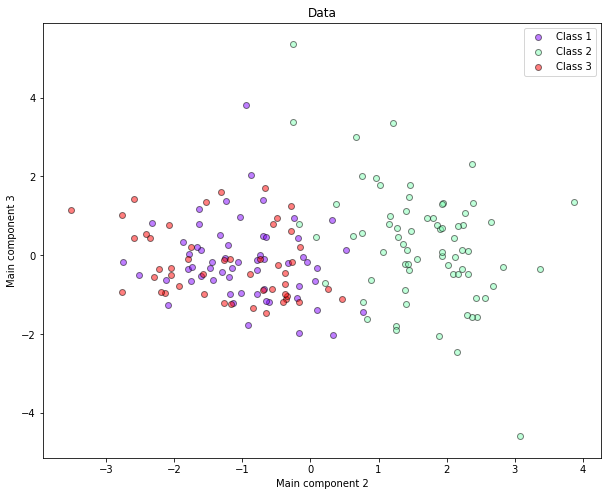

In [46]:
sklearn_pca = PCA(n_components=3)
sklearn_transf = sklearn_pca.fit_transform(X_scaled)
plt.figure(figsize = (10, 8))
plt.xlabel('Main component 2')
plt.ylabel('Main component 3')
plt.title('Most significant singular vectors after linear transformation through PCA')
plot_data(sklearn_transf[:,1:3],labels)

In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [48]:
x = sklearn_transf
y = wine_df['Wine']

#x.shape, y.shape

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=.2)

In [49]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(x_train, y_train)

y_predict = knn.predict(x_test)

accuracy_score(y_predict, y_test)

0.9722222222222222

### Learning representation

In this part we will work with a sample of the Mnist image set containing 1500 images of handwritten digits. We will apply dimensionality reduction and evaluate these tools in classification tasks.

In [50]:
mnist = pd.read_csv("../Datasets/Week9/mnist1.5k.csv",  header=None).values
d=mnist[:,1:785]
c=mnist[:,0]
print("Dimension of the images and classes: ", d.shape, c.shape)

Dimension of the images and classes:  (1500, 784) (1500,)


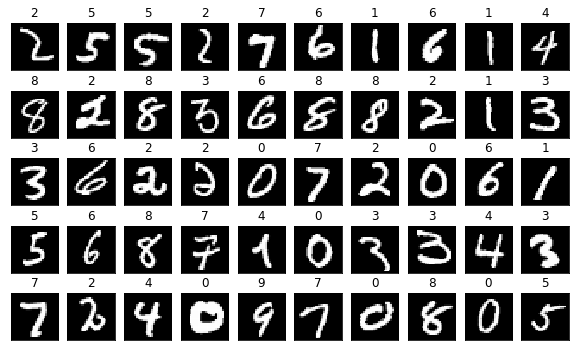

In [51]:
perm = np.random.permutation(range(d.shape[0]))[0:50]
random_imgs   = d[perm]
random_labels = c[perm] 
fig = plt.figure(figsize=(10,6))
for i in range(random_imgs.shape[0]):
    ax=fig.add_subplot(5,10,i+1)
    plt.imshow(random_imgs[i].reshape(28,28), interpolation="nearest", cmap = plt.cm.Greys_r)
    ax.set_title(int(random_labels[i]))
    plt.xticks([]); plt.yticks([])
    #ax.set_xticklabels([])
    #ax.set_yticklabels([])

### Applying analysis of the first 60 main components

In [52]:
X=mnist[:,1:785]
y=mnist[:,0]

Next we graph the cumulative curve of the explained variance versus the number of principal components, where we can observe the following:
   * The first 10 main components represent 49.2% of the variance of the data
   * The first 60 main components represent 86.2% of the variance of the data
   * The first 100 main components represent 92.3% of the variance of the data

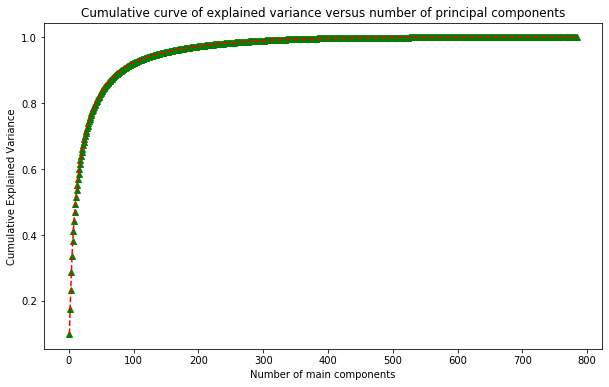

0.4928834387642885 0.8618011213919716 0.9230214472633833


In [53]:
sklearn_pca = PCA (n_components = None)
sklearn_transf = sklearn_pca.fit_transform (X)
variance_expl = sklearn_pca.explained_variance_ratio_
variance_expl

cum_var_exp = np.cumsum (variance_expl)
plt.figure (figsize = (10, 6))
plt.xlabel ('Number of main components')
plt.ylabel ('Cumulative Explained Variance')
plt.title ('Cumulative curve of explained variance versus number of principal components')
nc = np.arange (1, variance_expl.shape [0] + 1)
plt.plot (nc, cum_var_exp, 'g ^')
plt.plot (nc, cum_var_exp, '--r')
plt.show ()
print (np.sum (variance_expl[0:10]), np.sum(variance_expl [0:60]), np.sum(variance_expl[0: 100]))

Below we use the first 10 main components:

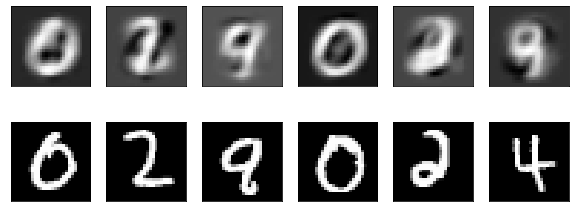

In [54]:
pca = PCA(n_components=10)
Xp = pca.fit_transform(X)
Xr = pca.inverse_transform(Xp)
plt.figure(figsize=(10,6))
for i in range(6):
    plt.subplot(3,6,i+1)
    k = np.random.randint(len(X))
    plt.imshow(Xr[k].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])
    plt.subplot(3,6,6+i+1)
    plt.imshow(X[k].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])

Below we use the first 60 main components:

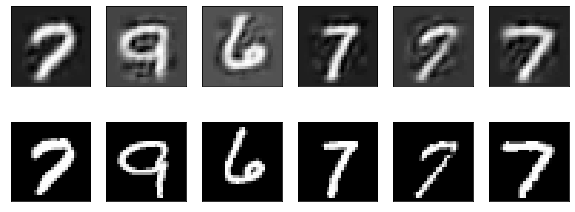

In [55]:
pca = PCA(n_components=60)
Xp = pca.fit_transform(X)
Xr = pca.inverse_transform(Xp)
plt.figure(figsize=(10,6))
for i in range(6):
    plt.subplot(3,6,i+1)
    k = np.random.randint(len(X))
    plt.imshow(Xr[k].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])
    plt.subplot(3,6,6+i+1)
    plt.imshow(X[k].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])

Below we use the first 100 main components:

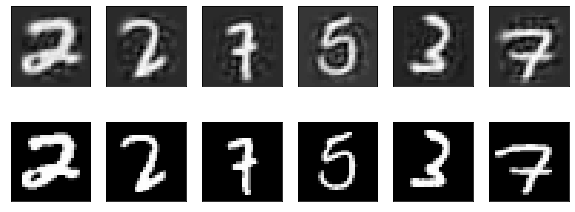

In [56]:
pca = PCA(n_components=100)
Xp = pca.fit_transform(X)
Xr = pca.inverse_transform(Xp)
plt.figure(figsize=(10,6))
for i in range(6):
    plt.subplot(3,6,i+1)
    k = np.random.randint(len(X))
    plt.imshow(Xr[k].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])
    plt.subplot(3,6,6+i+1)
    plt.imshow(X[k].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])

### Classification in the new representation space

In [57]:
#from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

print ("Accuracy with original data:", np.mean (cross_val_score (GaussianNB (), X, y, cv = 5)))
print ("Accuracy with new representation:", np.mean (cross_val_score (GaussianNB (), Xp, y, cv = 5)))

Accuracy with original data: 0.5919753397822902
Accuracy with new representation: 0.8281086348380752


### Observe the new representation of the first image

In [58]:
Xp[0]

array([-630.21531393,  730.97102697, -103.800336  ,  -96.74972387,
       -147.33798785, -469.26160585, -411.86646565, -603.64391366,
        163.46361845, -244.03467753, -264.6911468 ,   -7.50376124,
        -93.39721154, -315.3143367 ,  299.18095328,   43.2868153 ,
        -14.66274435,  373.48496893,  173.24271714,  -69.40940154,
         87.6473357 , -271.77941161,   32.25153021,   -2.67043844,
        146.24544406, -194.56021832,   -6.74774744, -130.69934235,
        279.14281264,  -79.7636435 ,  -44.83933481,  112.8959887 ,
         23.97556838,  172.07787885,  113.19391085, -136.91086279,
       -102.95291113,   14.81117654, -243.58722636,   85.79117682,
         53.48396323,   -6.09405982, -127.40332397,  161.38318417,
         57.7051754 ,  -46.70534353,   25.45122355,   44.00388982,
       -114.75066235,   22.63932398,  110.21884946,  -74.39642902,
        128.17169954,   14.35502851, -109.50464617,   14.76791041,
         68.03846874,   87.2463616 ,   53.31724695,    9.02577

# Demonstration

## Reduction of dimensionality and grouping
1. Next we are going to load the dataset of movements in the bag that is in the location `data / company-stock-movements-2010-2015-incl.csv.gz`
2. We convert all values to 1 if> 0 and -1 otherwise
3. We apply PCA with 2 components to the newly modified data set (with + 1 / -1)
4. We plot the cumulative curve of explained variance versus the number of principal components.
     * How many components are sufficient to present 70%, 80%, 90% of the variance of the data?
5. Use KMeans with 7 clusters
6. Visualize the KMeans clusters in the 2D plane given by PCA

In [59]:
from sklearn.decomposition import PCA
d = pd.read_csv("../Datasets/Week9/company-stock-movements-2010-2015-incl.csv", index_col=0)

In [60]:
d.head(4)

,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-11,2010-01-12,2010-01-13,2010-01-14,2010-01-15,...,2013-10-16,2013-10-17,2013-10-18,2013-10-21,2013-10-22,2013-10-23,2013-10-24,2013-10-25,2013-10-28,2013-10-29
Apple,0.580000,-0.220005,-3.409998,-1.170000,1.680011,-2.689994,-1.469994,2.779997,-0.680003,-4.999995,...,0.320008,4.519997,2.899987,9.590019,-6.540016,5.959976,6.910011,-5.359962,0.840019,-19.589981
AIG,-0.640002,-0.650000,-0.210001,-0.420000,0.710001,-0.200001,-1.130001,0.069999,-0.119999,-0.500000,...,0.919998,0.709999,0.119999,-0.480000,0.010002,-0.279998,-0.190003,-0.040001,-0.400002,0.660000
Amazon,-2.350006,1.260009,-2.350006,-2.009995,2.960006,-2.309997,-1.640007,1.209999,-1.790001,-2.039994,...,2.109985,3.699982,9.570008,-3.450013,4.820008,-4.079986,2.579986,4.790009,-1.760009,3.740021
American express,0.109997,0.000000,0.260002,0.720002,0.190003,-0.270001,0.750000,0.300004,0.639999,-0.130001,...,0.680001,2.290001,0.409996,-0.069999,0.100006,0.069999,0.130005,1.849999,0.040001,0.540001


In [61]:
def convert(x):
  if x > 0:
    return 1
  else:
    return -1

In [62]:
vec_converter = np.vectorize(convert)

In [63]:
d_tr = d.apply(vec_converter)
d_tr.head(4)

,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-11,2010-01-12,2010-01-13,2010-01-14,2010-01-15,...,2013-10-16,2013-10-17,2013-10-18,2013-10-21,2013-10-22,2013-10-23,2013-10-24,2013-10-25,2013-10-28,2013-10-29
Apple,1,-1,-1,-1,1,-1,-1,1,-1,-1,...,1,1,1,1,-1,1,1,-1,1,-1
AIG,-1,-1,-1,-1,1,-1,-1,1,-1,-1,...,1,1,1,-1,1,-1,-1,-1,-1,1
Amazon,-1,1,-1,-1,1,-1,-1,1,-1,-1,...,1,1,1,-1,1,-1,1,1,-1,1
American express,1,-1,1,1,1,-1,1,1,1,-1,...,1,1,1,-1,1,1,1,1,1,1


In [64]:
sklearn_pca = PCA(n_components=2)
X = sklearn_pca.fit_transform(d_tr.values)
X.shape

(60, 2)

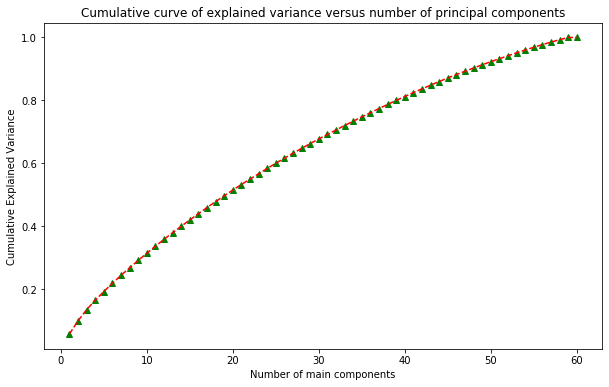

0.31473824186437493 0.5153806053333401 0.9999999999999998


In [65]:
pca = PCA (n_components = None)
pca.fit_transform (d_tr.values)
variance_expl = pca.explained_variance_ratio_
variance_expl

cum_var_exp = np.cumsum (variance_expl)
plt.figure (figsize = (10, 6))
plt.xlabel ('Number of main components')
plt.ylabel ('Cumulative Explained Variance')
plt.title ('Cumulative curve of explained variance versus number of principal components')
nc = np.arange (1, variance_expl.shape [0] + 1)
plt.plot (nc, cum_var_exp, 'g ^')
plt.plot (nc, cum_var_exp, '--r')
plt.show ()
print (np.sum (variance_expl [0:10]), np.sum (variance_expl [0:20]), np.sum (variance_expl [0:60]))

In [66]:
from sklearn.cluster import KMeans

In [67]:
n_clusters = 7

y = KMeans(n_clusters=n_clusters).fit_predict(X)
y.shape

(60,)

Check your code. It should appear roughly like this:

![Stock Image](https://i.imgur.com/8f2LgxK.png)

(-11.384137668762213,
 16.830200626258616,
 -10.025352846178189,
 13.07652464151224)

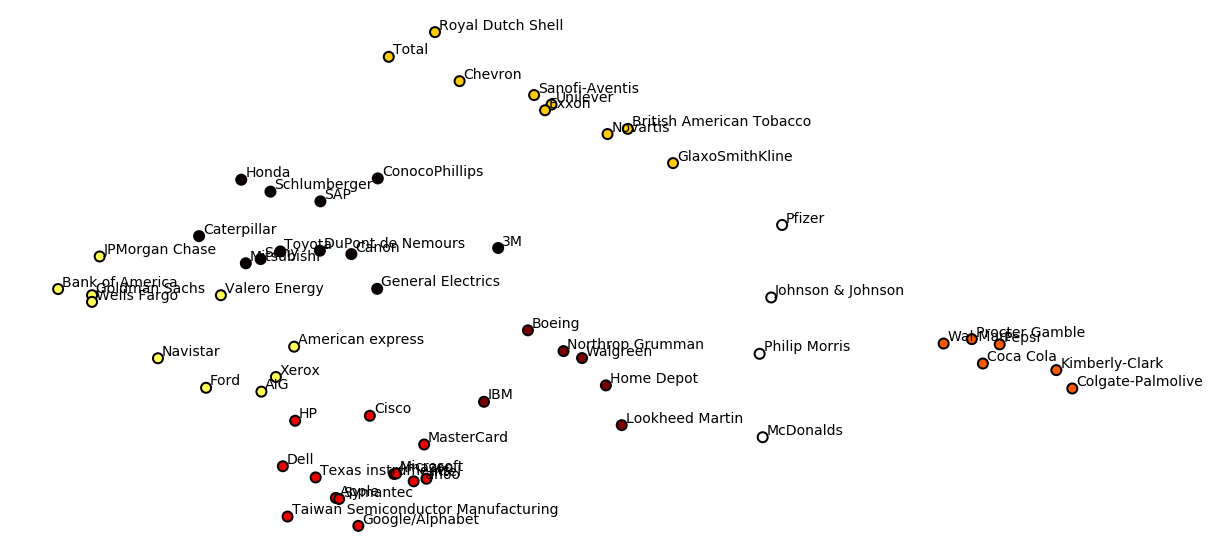

In [68]:
cmap = plt.cm.hot
plt.figure(figsize=(20,10))
plt.scatter(X[:,0], X[:,1], color=cmap((y*255./(n_clusters-1)).astype(int)), s=100, edgecolor="black", lw=2)
for i in range(len(d)):
    name = d.index[i]
    plt.text(X[i,0]+.1, X[i,1]+.1, d.index[i], fontsize=14)
plt.axis("off")

## Dimensionality reduction for set of face images
   1. Next we will load the set of face images that is in the location `data / faces.pkl`
   2. We plot the cumulative curve of explained variance versus the number of principal components.
     * How many components are sufficient to present 70%, 80%, 90% of the variance of the data?
   3. Reconstruct the face images with the number of components of 70%, 80% and 90% of the variance

In [69]:
# https://docs.google.com/uc?export=download&id=1y4rB16HEdEPV3WtBUFbpLQGPtrEMNrox

In [70]:
import pickle

faces = []

with open("../Datasets/Week9/faces.pkl", "rb") as file:
    faces = pickle.load(file, encoding='latin1')

faces.shape

(535, 361)

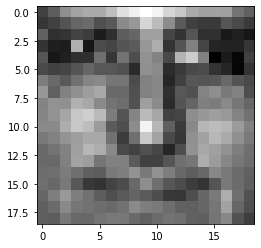

In [71]:
# Show faces 
plt.imshow(np.abs(faces[0]).reshape((19,19)), cmap="gray")

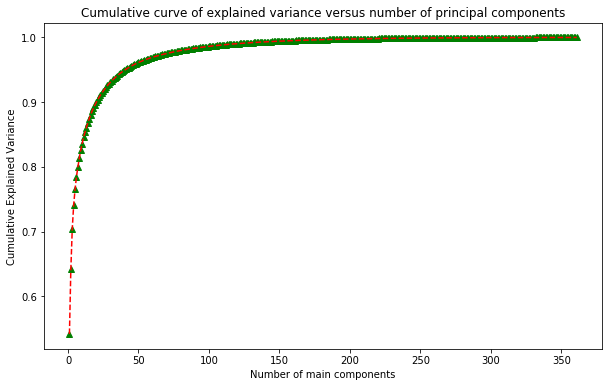

0.8360191379770132 0.9694738802606883 0.9862940417983698


In [72]:
sklearn_pca = PCA (n_components = None)
sklearn_transf = sklearn_pca.fit_transform (faces)
variance_expl = sklearn_pca.explained_variance_ratio_
variance_expl

cum_var_exp = np.cumsum (variance_expl)
plt.figure (figsize = (10, 6))
plt.xlabel ('Number of main components')
plt.ylabel ('Cumulative Explained Variance')
plt.title ('Cumulative curve of explained variance versus number of principal components')
nc = np.arange (1, variance_expl.shape [0] + 1)
plt.plot (nc, cum_var_exp, 'g ^')
plt.plot (nc, cum_var_exp, '--r')
plt.show ()
print (np.sum (variance_expl[0:10]), np.sum (variance_expl[0:60]), np.sum (variance_expl[0: 100]))

In [73]:
print("n_components to explain 70% of variance: {}".format(np.sum(np.cumsum(varianza_expl)<=0.7)))
print("n_components to explain 80% of variance: {}".format(np.sum(np.cumsum(varianza_expl)<=0.8)))
print("n_components to explain 90% of variance: {}".format(np.sum(np.cumsum(varianza_expl)<=0.9)))

n_components to explain 70% of variance: 3
n_components to explain 80% of variance: 4
n_components to explain 90% of variance: 7


In [74]:
from sklearn.metrics import mean_squared_error

Rebuild error with 2 components: 672.3270918802792
Rebuild error with 7 components: 375.63061522166834
Rebuild error with 20 components: 188.46445610954237


C:\Users\TheGlitchCat\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]
C:\Users\TheGlitchCat\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]
C:\Users\TheGlitchCat\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


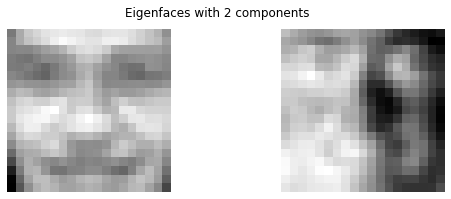

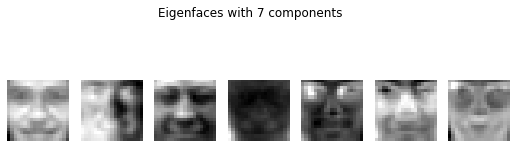

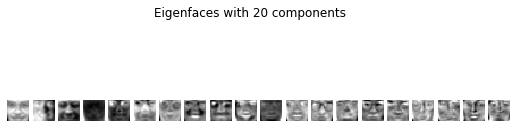

In [75]:
# reconstruimos con distinto número de componentes
for n in [2,7, 20]:
  pca = PCA(n_components=n)
  X_tr = pca.fit_transform(faces)
  # print reconstruction error 
  print("Rebuild error with {} components: {}".format(n, mean_squared_error(faces, pca.inverse_transform(X_tr))))
  # print reducced faces 
  fig, axes = plt.subplots(1,n,figsize=(9,3))
  fig.suptitle("Eigenfaces with {} components".format(n))
  for i in range(0,n):
    axes[i].imshow(pca.components_[i].reshape(19,19), cmap="gray")
    axes[i].axis("off")
    fig.show()

### Kernels 

is a mathematical function that takes measurements that behave non-linearly and projects them into a larger dimensional space where they are linearly separable

<img src='https://miro.medium.com/max/838/1*gXvhD4IomaC9Jb37tzDUVg.png'>

### Common Kernels:

- Linear: $$K(x,y) = x * y$$
- Polynomial: $$ K(x,y) = (x * y)^p $$
- Gaussian (RBF): $$ K(x,y) = e^{-\frac{||x - y||^2}{2\alpha^2}}$$

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_iris_svc_0011.png">

In [76]:
from sklearn.decomposition import KernelPCA as KPCA

# Reload our variables
df = pd.read_csv('../Datasets/Week9/heart.csv')
df.head()

x = df.drop(['target'], 1)
y = df['target']

x = StandardScaler().fit_transform(x) 

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.3)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

kpca = KPCA(n_components=4, kernel='poly')

kpca.fit(x_train)

# Reload our model

lr = LogisticRegression(solver='lbfgs')

lr.fit(x_train, y_train)
print('Without KPCA: ', lr.score(x_test, y_test))

x_pca_train = kpca.transform(x_train)
x_pca_test = kpca.transform(x_test)
lr.fit(x_pca_train, y_train)
print('With KPCA: ', lr.score(x_pca_test, y_test))



Without KPCA:  0.8538961038961039
With KPCA:  0.8051948051948052


### Regularization

Regularization consists of reducing the complexity of the model through a penalty applied to its most irrelevant variables.

more bias less variance 

<img src="https://cdn-images-1.medium.com/freeze/max/1000/1*p3AvLHA7-jfiDWKoHzMO-g.jpeg?q=20">

### Loss in training and validation

<img src="https://i1.wp.com/mlexplained.com/wp-content/uploads/2018/04/three_curve.png?fit=418%2C341&ssl=1">

- Types:
    - **L1 Lasso**: reduce complexity by eliminating features that do not add much to the model (- features)
    <br>
    $$ \hat{\beta} = arg \min_{\beta} \sum_{i = 1}^{n} \left( y_{i} - \beta_{0} - \sum_{j=1}^{p} \beta_{j} X_{ij}\right) ^ 2 + \left(\lambda \sum_{j=1} ^ {p} |\beta_{j}|\right)_{Penalty} $$
    <br>
    - **L2 Ridge**: reduce complexity by reducing the impact of certain features on our model (+ features)
    <br>
    $$ \hat{\beta} = arg \min_{\beta} \sum_{i = 1}^{n} \left( y_{i} - \beta_{0} - \sum_{j=1}^{p} \beta_{j} X_{ij}\right) ^ 2 + \left(\lambda \sum_{j=1} ^ {p} \beta_{j}^2\right)_{Penalty} $$
    <br>
    - **ElasticNet**: combination of the previous two

### Other Dataset

#### World Happiness
1. country: Country of reference 
2. rank: Place in the range according to the descending score. 
3. score: Subjective perception of happiness on a scale of 0 to 10. 
4. high: (High Whisker): 3 quartile of the score. 
5. low: (Low Whisker): 1 quartile of the score. 
6. gdp: Gross domestic product per capita. 
7. family: Perceived measure of the support of family ties. 
8. lifexp: Life expectancy drawn from the WHO. 
9. freedom: Perception of freedom to make decisions. 
10. generosity: Calculated on the question, Have you donated money in the last month? 
11. corruption: Citizens' perception of whether or not there is corruption. 
12. dystopia: Comparison index with an imaginary country where all aspects are in the worst possible state.

In [77]:
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error


In [78]:
df = pd.read_csv('../Datasets/Week9/world_happiness.csv')
df.head()

,country,rank,score,high,low,gdp,family,lifexp,freedom,generosity,corruption,dystopia
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,3,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,4,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,5,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


In [79]:
df.describe()

,rank,score,high,low,gdp,family,lifexp,freedom,generosity,corruption,dystopia
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000
mean,78.000000,5.354019,5.452326,5.255713,0.984718,1.188898,0.551341,0.408786,0.246883,0.123120,1.850238
std,44.888751,1.131230,1.118542,1.145030,0.420793,0.287263,0.237073,0.149997,0.134780,0.101661,0.500028
min,1.000000,2.693000,2.864884,2.521116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.377914
25%,39.500000,4.505500,4.608172,4.374955,0.663371,1.042635,0.369866,0.303677,0.154106,0.057271,1.591291
50%,78.000000,5.279000,5.370032,5.193152,1.064578,1.253918,0.606042,0.437454,0.231538,0.089848,1.832910
75%,116.500000,6.101500,6.194600,6.006527,1.318027,1.414316,0.723008,0.516561,0.323762,0.153296,2.144654
max,155.000000,7.537000,7.622030,7.479556,1.870766,1.610574,0.949492,0.658249,0.838075,0.464308,3.117485


In [80]:
x = df.drop(['rank','score', 'country', 'high','low'],1)
y = df['score']

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25)

In [81]:
linear = LinearRegression().fit(x_train, y_train)
linear_pred = linear.predict(x_test)


# alpha == lambda in equation
# alpha is directly proportional to the penalty
lasso = Lasso(alpha=0.02).fit(x_train, y_train)
lasso_pred = lasso.predict(x_test)

# default alpha = 1 
ridge = Ridge(alpha=1).fit(x_train, y_train)
ridge_pred = ridge.predict(x_test)

elastic = ElasticNet(random_state=0).fit(x_train, y_train)
elastic_pred = elastic.predict(x_test)


linear_loss = mean_squared_error(y_test, linear_pred)
lasso_loss = mean_squared_error(y_test, lasso_pred)
ridge_loss = mean_squared_error(y_test, ridge_pred)
elastic_loss = mean_squared_error(y_test, elastic_pred)


print(f'Linear loss: {linear_loss}')
print(f'Lasso loss: {lasso_loss}')
print(f'Ridge loss: {ridge_loss}')
print(f'ElasticNet loss: {elastic_loss}')


print('-'*32)
print('coefficients')
print(f'Lasso: {lasso.coef_}')
print(f'Ridge: {ridge.coef_}')
print(f'ElasticNet: {elastic.coef_}')


Linear loss: 8.90892219110379e-08
Lasso loss: 0.08349421228623055
Ridge loss: 0.008054004889052694
ElasticNet loss: 1.4247961980566122
--------------------------------
coefficients
Lasso: [1.44095896 0.87245622 0.19084339 0.81035506 0.06457478 0.
 0.92537801]
Ridge: [1.1040361  0.9539943  0.80899761 0.90352795 0.72535264 0.62693251
 0.96961099]
ElasticNet: [0. 0. 0. 0. 0. 0. 0.]
